# MSCA 31009 - Deep Learning Final Project
By: Sydney Peters<br>
Date: 27 May 2023

There is a class project that is done by each students. The purpose of the project is to test the students’
ability to apply the machine learning techniques and tools presented in the class to diverse practical
problems and interpret & apply the results.

The class project covers:
- Choose a real-world machine learning problem with an objective
- Procure and analyze the data
- Develop a deep learning or recommender system model
- Outline data / model assumptions & limitations / hypotheses
- Evaluate model metrics such as overfitting / underfitting
- Select final model based on selection criteria
- Determine how the model can be improved
- Effectively communicate analytical work

For the class project, students are graded on 8 criteria outlined below. Each criterion is 5 points for a
total of 40 points. The criteria are:
1. Problem Statement
2. Assumptions/Hypotheses about data and model
3. Exploratory Data Analysis
4. Feature Engineering & Transformations
5. Proposed Approaches (Model) with checks for overfitting/underfitting
6. Proposed Solution (Model Selection) with regularization, if needed
7. Results (Accuracy) and Learnings from the methodology
8. Future Work

# Deep Learning Model to Predict Stage of Alzheimer's Disease from MRI Scans

## Dataset consists of MRI images and has four classes of images both in training as well as a testing set:
1. Mild Demented
2. Moderate Demented
3. Non Demented
4. Very Mild Demented

I am referencing a previously made model on Kaggle and seeing if I can improve it/glean more insights from it. Here's the link to the Kaggle:<br>
<b>Alzheimer MRI Model + TensorFlow 2.3 Data Loading<br>
https://www.kaggle.com/code/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.14.0-dev20230525


In [3]:
# set constant variables instead of hard coding numbers
# saves time later when we want to change certain parameters

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 50

## Load the Data

In [4]:
train_dir = "../Desktop/alzheimers/train"

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [6]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

In [7]:
# shapes of individual batches
for images, labels in train_ds:
    print(images.shape)  # Shape of the batch of images
    print(labels.shape)  # Shape of the batch of labels
    break  # Only print the shape of the first batch

(16, 176, 208, 3)
(16,)


In [8]:
# total number of samples in the dataset
num_samples = tf.data.experimental.cardinality(train_ds).numpy()
print(num_samples)

257


## Visualize the Data

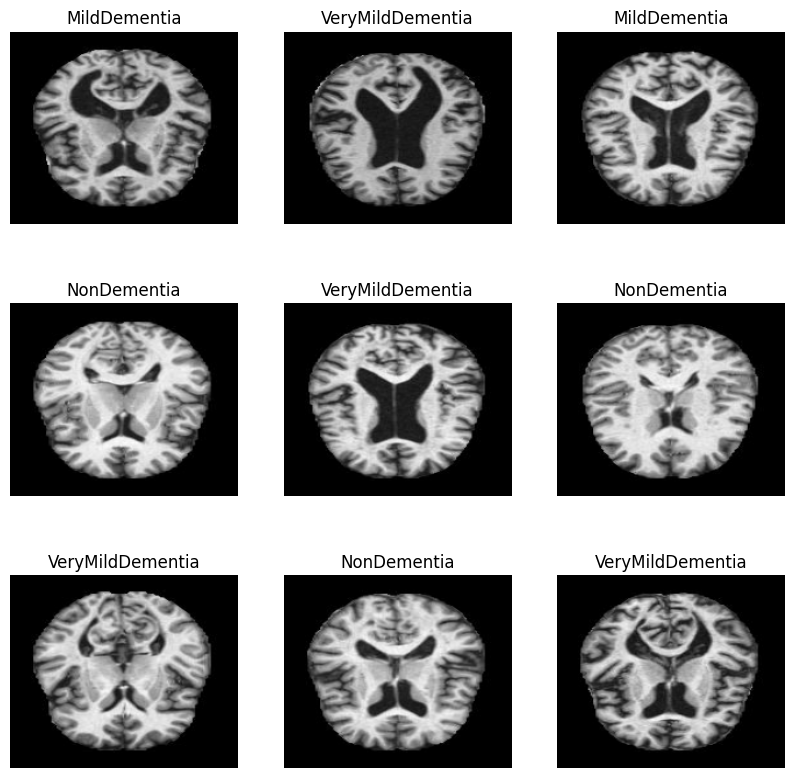

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

## Feature Engineering

<b> One-Hot Encoding for Categorial Variables

In [10]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print(label)

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]], shape=(16, 4), dtype=float32)


<b> Cache datasets for quicker image retrieval

In [12]:
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_images = []

for label in class_names:
    dir_name = train_dir + '/' + label[:-2] + 'ed'
    num_images.append(len([name for name in os.listdir(dir_name)]))

In [14]:
num_images

[717, 52, 2560, 1792]

<b> Number of images in the dataset isn't balanced, so we can't use accuracy for our model metric. As a different option, ROC AUC gives a score for the model. Higher scores closer to 1 indicate that different classes can be distinguishable for the model. Lower score closer to 0 indicates that the the model can't distinguish between different classes. 0.5 indicates that the ordering the images is pretty much random.

## Initial Classifier Build
- Use keras to build an initial image classifier with the following specifications.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import metrics

### Create an instance of Sequential called "classifier"

In [16]:
classifier = Sequential()

### Add a Conv2D layer with the following parameters:
- filters = 16
- kernel_size = 3
- activation = 'relu'
- padding = same'

In [17]:
classifier.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'))

### Add another Conv2D layer with the same parameters:
- filters = 16
- kernel_size = 3
- activation = 'relu'
- padding = same'

In [18]:
classifier.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'))

### Add a BatchNormalization layer

In [19]:
classifier.add(BatchNormalization())

### Add a MaxPooling2D layer 

In [20]:
classifier.add(MaxPooling2D())

### Add a Dense Layer with the following parameters:
- units = 128
- activation = 'relu'

In [21]:
classifier.add(Dense(units=16, activation='relu'))

### Add a BatchNormalization layer

In [22]:
classifier.add(BatchNormalization())

### Add a Dropout layer
- rate = 0.2

In [23]:
classifier.add(Dropout(0.2))

### Compile with the following:
- optimize = adam
- loss = categorical cross entropy
- metric = auc-roc

In [24]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.AUC()])

Use .fit() with the training set. For the first run, use the following parameters:
- Now use keras to build an initial image classifier with
    - steps_per_epoch = 3
    - epochs = 3

## Build Model

In [26]:
classifier.fit(train_ds, steps_per_epoch=3, epochs=3)
## I kept getting errors that ValueError: Shapes (None, 4) and (None, 88, 104, 128) are incompatible
# and I don't have time to work through them so this is a next step

Epoch 1/3


TypeError: 'NoneType' object is not callable

In [27]:
import numpy as np

# Step 1: Check the current shape of target labels
print(labels.shape)

# Step 2: Transform labels to shape (None, 4)
new_labels = []
for label in labels:
    # Step 3: Apply label transformation logic
    transformed_label = np.argmax(label)  # Assuming labels are one-hot encoded
    new_labels.append(transformed_label)

# Step 4: Convert new_labels to a numpy array
new_labels = np.array(new_labels)

# Step 5: Verify the shape of new_labels
print(new_labels.shape)


(16,)
(16,)


In [28]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [29]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [31]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

## Train Model
- Using callbacks to more efficiently train our model, adjusting our learning rate to stop model once it converges.
- LR is crucial in this model.
- If LR that is too high, prevents model from converging
- LR that is too slow will make process too computationally expensive
- Stopping model early is one mechanism that prevents overfitting

In [32]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [38]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     callbacks=[early_stopping_cb, lr_scheduler],
#     epochs=EPOCHS
# )

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
257/257 [==============================] - 47s 182ms/step - loss: 0.7058 - auc: 0.9087 - val_loss: 2.0531 - val_auc: 0.8244
Epoch 2/50
257/257 [==============================] - 47s 184ms/step - loss: 0.6425 - auc: 0.9254 - val_loss: 0.8675 - val_auc: 0.8704
Epoch 3/50
257/257 [==============================] - 50s 194ms/step - loss: 0.6105 - auc: 0.9324 - val_loss: 1.6078 - val_auc: 0.8546
Epoch 4/50
257/257 [==============================] - 50s 195ms/step - loss: 0.5456 - auc: 0.9464 - val_loss: 0.4980 - val_auc: 0.9548
Epoch 5/50
257/257 [==============================] - 51s 196ms/step - loss: 0.4816 - auc: 0.9583 - val_loss: 0.5896 - val_auc: 0.9459
Epoch 6/50
257/257 [==============================] - 49s 190ms/step - loss: 0.5126 - auc: 0.9528 - val_loss: 0.4684 - val_auc: 0.9613
Epoch 7/50
257/257 [==============================] - 55s 213ms/step - loss: 0.4327 - auc: 0.9662 - val_loss: 1.8761 - val_auc: 0.8554
Epoch 8/50
257/257 [==============================] - 7

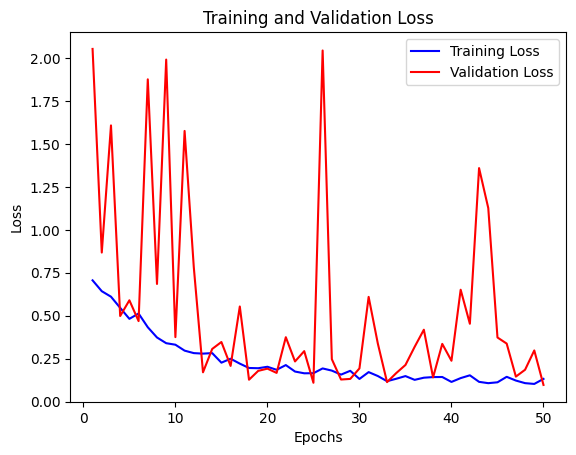

In [40]:
# Get the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

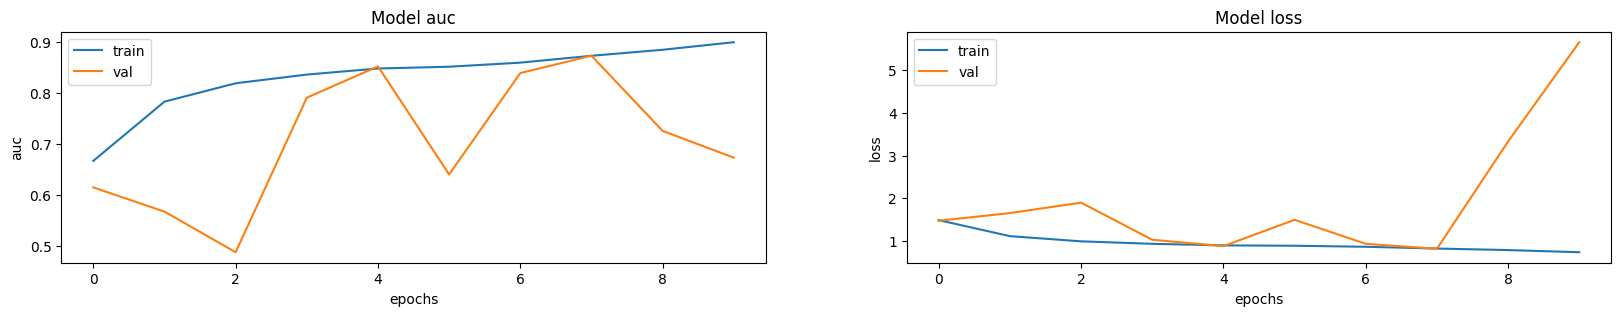

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
test_dir = "../Desktop/alzheimers/test"

In [36]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


80/80 [==============================] - 3s 42ms/step - loss: 1.5586 - auc: 0.8529


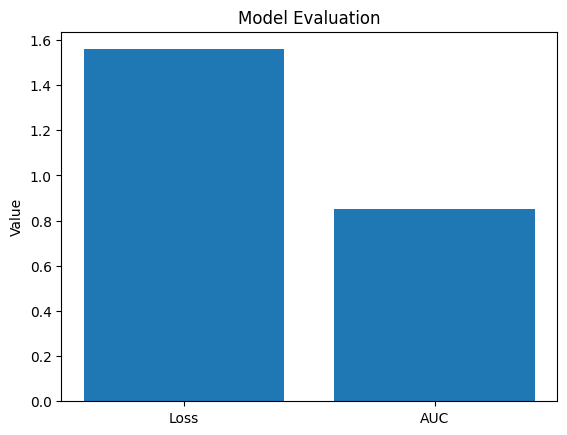

In [41]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
loss, auc = model.evaluate(test_ds)

# Create a bar plot to display the evaluation results
metrics = ['Loss', 'AUC']
values = [loss, auc]

plt.bar(metrics, values)
plt.ylabel('Value')
plt.title('Model Evaluation')
plt.show()